In [4]:
! pip install -q git+https://github.com/keras-team/keras-cv

In [5]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# To ignore all warnings
import warnings
warnings.filterwarnings("ignore")

2024-05-08 15:30:12.206189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 15:30:12.206293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 15:30:12.341502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [6]:
BASE_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
TRAIN_CSV = f"{BASE_PATH}/train.csv"

In [7]:
data = pd.read_csv(TRAIN_CSV)
data.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [8]:
# Checking the summary statistics of the dataset
summary_statistics = data.describe()

summary_statistics.iloc[1]

patient_id               32664.239593
bowel_healthy                0.979663
bowel_injury                 0.020337
extravasation_healthy        0.936447
extravasation_injury         0.063553
kidney_healthy               0.942167
kidney_low                   0.036543
kidney_high                  0.021290
liver_healthy                0.897998
liver_low                    0.082301
liver_high                   0.019701
spleen_healthy               0.887512
spleen_low                   0.063235
spleen_high                  0.049253
any_injury                   0.271687
Name: mean, dtype: float64

In [9]:
# Checking for missing values
missing_values = data.isnull().sum()

missing_values

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
dtype: int64

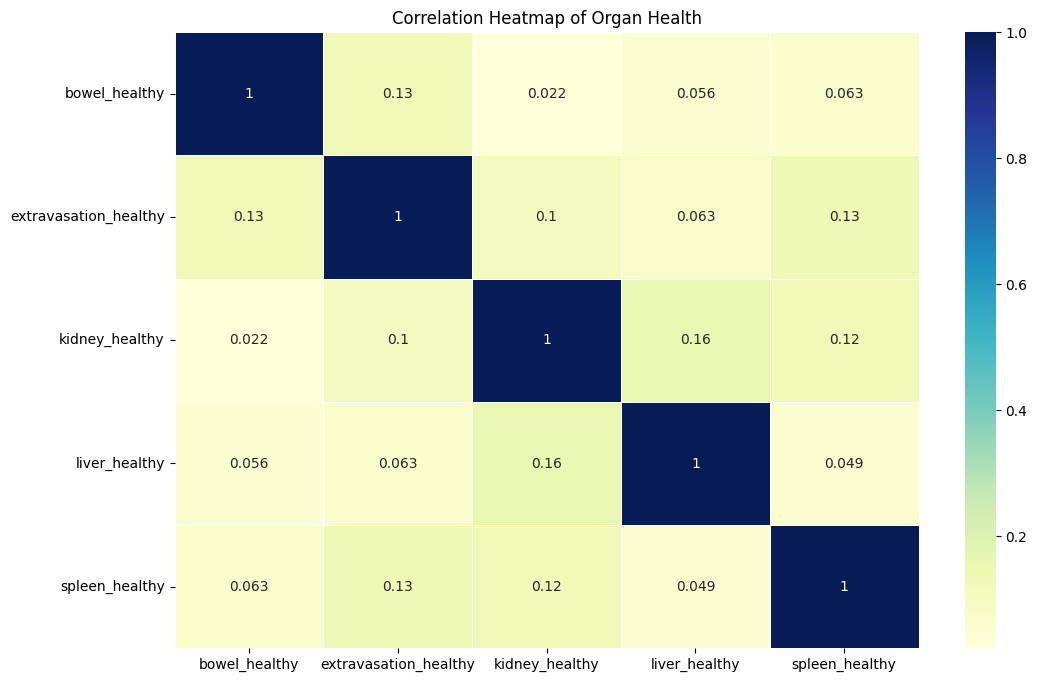

In [10]:
# Selecting columns related to the health of organs
health_columns = [
    "bowel_healthy", "extravasation_healthy", "kidney_healthy", 
    "liver_healthy", "spleen_healthy",
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = data[health_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Health")
plt.show()

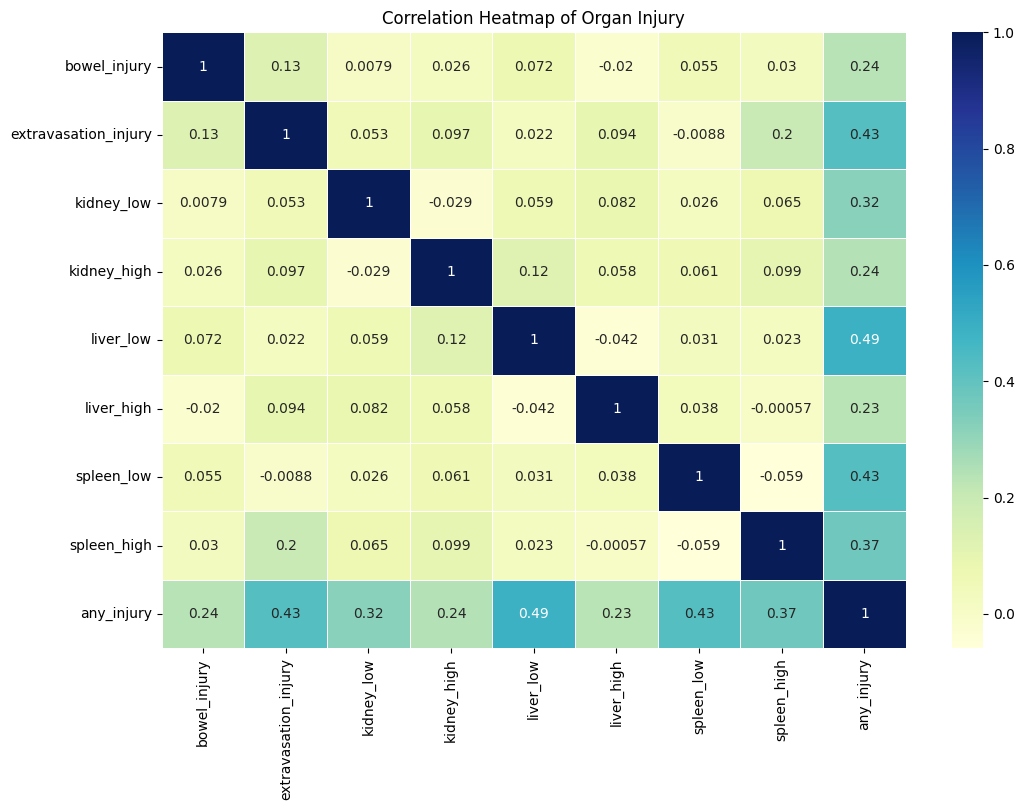

In [11]:
# Selecting columns related to the health of organs
injury_columns = [
    "bowel_injury", "extravasation_injury",
    "kidney_low", "kidney_high", 
    "liver_low", "liver_high",
    "spleen_low", "spleen_high",
    "any_injury"
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = data[injury_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Injury")
plt.show()

In [12]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 20
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [13]:
keras.utils.set_random_seed(seed=config.SEED)

In [14]:
BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-v2-dataset"

In [15]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


In [16]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [17]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

In [18]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            
        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [19]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

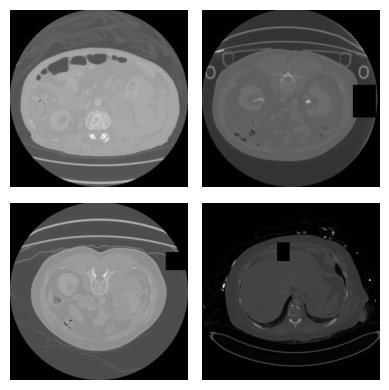

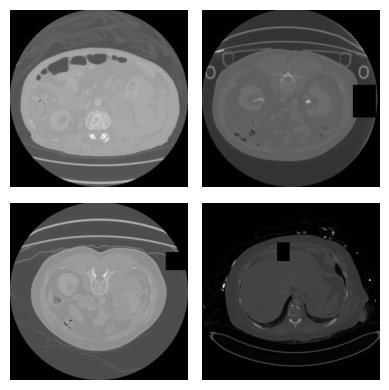

In [20]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D

def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Use ResNet50 as the backbone
    backbone = ResNet50(weights='imagenet', include_top=False)
    x = backbone(inputs)

    # GAP to get the activation maps
    x = GlobalAveragePooling2D()(x)

    # Define 'necks' for each head
    x_bowel = Dense(32, activation='silu')(x)
    x_extra = Dense(32, activation='silu')(x)
    x_liver = Dense(32, activation='silu')(x)
    x_kidney = Dense(32, activation='silu')(x)
    x_spleen = Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": ["accuracy"],
        "extra": ["accuracy"],
        "liver": ["accuracy"],
        "kidney": ["accuracy"],
        "spleen": ["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model


In [22]:
# Assuming you have already defined the necessary functions like build_dataset

# Build the dataset
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values
train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values
valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# Train and valid datasets
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

# Build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# Train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)


[INFO] Building the dataset...
total_train_steps=193280
warmup_steps=19328
decay_steps=173952
[INFO] Building the model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/20


2024-05-08 15:31:32.011849: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,8,8]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-08 15:31:32.293035: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.281294449s
Trying algorithm eng0{} for conv (f32[64,1024,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,8,8]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-08 15:31:33.322408: E external/

151/151 ━━━━━━━━━━━━━━━━━━━━ 229s 908ms/step - bowel_accuracy: 0.9454 - extra_accuracy: 0.9099 - kidney_accuracy: 0.8382 - liver_accuracy: 0.8311 - loss: 1.6616 - spleen_accuracy: 0.8299 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 25.2060 - val_spleen_accuracy: 0.6773
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 84s 545ms/step - bowel_accuracy: 0.8106 - extra_accuracy: 0.9529 - kidney_accuracy: 0.8366 - liver_accuracy: 0.7262 - loss: 3.2779 - spleen_accuracy: 0.8200 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 5.6596 - val_spleen_accuracy: 0.6748
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 84s 544ms/step - bowel_accuracy: 0.7719 - extra_accuracy: 0.9518 - kidney_accuracy: 0.8681 - liver_accuracy: 0.7657 - loss: 2.6024 - spleen_accuracy: 0.8486 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.811

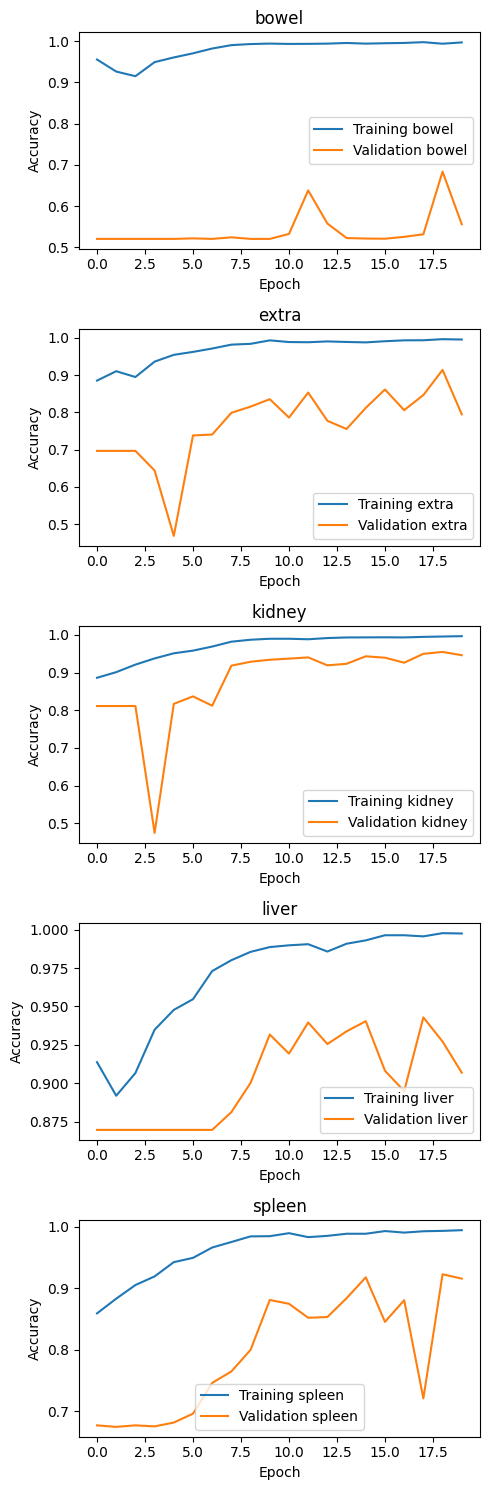

In [23]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

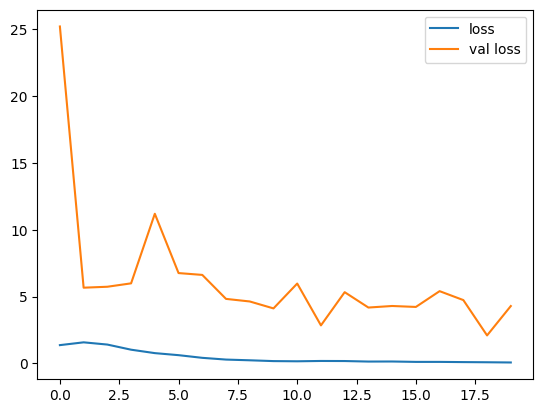

In [24]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [25]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 2.088
>>>> BEST Acc   : 0.881
>>>> BEST Epoch : 18

ORGAN Acc:
  >>>> Bowel           : 0.683
  >>>> Extravasation   : 0.914
  >>>> Liver           : 0.927
  >>>> Kidney          : 0.955
  >>>> Spleen          : 0.923


In [26]:
# Save the model
model.save("rsna-atd.keras")

In [28]:
! pip install keras-cv
! pip install tensorflow
! pip install pydicom
! pip install opencv-python
! pip install namex keras_core keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [33]:
! pip install tqdm


In [119]:
import glob  # Import the glob module
from tqdm import tqdm  # Import tqdm (assuming already imported)



In [85]:
! pip install --upgrade tensorflow


  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully unin

In [96]:
class CFG:
    debug         = False
    # device
    device = "GPU" # or "GPU"
    # seed for data-split, layer init, augs
    seed = 42
    # which folds of ckpt to use
    num_folds = 1
    # dicom to png size
    resize_dim = 512
    # size of training image
    img_size = [512, 512]
    # clip
    clip = False
    # lr-scheduler
    scheduler   = 'exp' # cosine
    # threshold
    thr = 0.50
    # target column
    target_col  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

In [97]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


In [98]:
BASE_PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
IMG_DIR = '/tmp/dataset/rsna-atd'
NUM_SLICES = 4 # how many dicom files to take per series (scans)

In [100]:
test_df = pd.read_csv(f'{BASE_PATH}/test_series_meta.csv')
test_df['dicom_folder'] = BASE_PATH + '/' + 'test_images'\
                                    + '/' + test_df.patient_id.astype(str)\
                                    + '/' + test_df.series_id.astype(str)
test_folders = test_df.dicom_folder.tolist()

test_paths = []
for folder in tqdm(test_folders):
    paths = sorted(glob.glob(os.path.join(folder, '*dcm')),
                   key=lambda x: int(x.split('/')[-1].split('.')[0]))
    NUM_DICOM = len(paths)
    if len(test_folders)>6: # private test; contains all dicom files/folders
        STRIDE = -(-NUM_DICOM // (NUM_SLICES + 4))
        test_paths += [paths[STRIDE:NUM_DICOM-3*STRIDE:STRIDE]]
    else: # we can't access all the test dicom files in public test
        test_paths += [paths]

test_df['dicom_paths'] = test_paths
test_df = test_df[test_df.dicom_paths.map(len)>0] # in public test not all folder contains dicom file

test_df['image_path'] = f'{IMG_DIR}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str) +'.png'
# test_df = test_df.drop_duplicates()

test_df.head(2)

100%|██████████| 6/6 [00:00<00:00, 951.70it/s]


,patient_id,series_id,aortic_hu,dicom_folder,dicom_paths,image_path
1,48843,62825,238.0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/tmp/dataset/rsna-atd/test_images/48843/62825.png
2,50046,24574,149.0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/tmp/dataset/rsna-atd/test_images/50046/24574.png


In [101]:
tf.io.gfile.exists(test_df.dicom_paths.iloc[0][0])

True

In [102]:
print('test_files:',test_df.shape[0])

test_files: 3


In [104]:
!rm -r /tmp/Dataset/rsna-atd
# os.makedirs('/tmp/dataset/rsna-atd/train_images', exist_ok = True)
os.makedirs(f'{IMG_DIR}/test_images', exist_ok = True)

rm: cannot remove '/tmp/Dataset/rsna-atd': No such file or directory


In [105]:
import cv2
import pydicom

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array


def read_xray(path, fix_monochrome = True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    IMG_SIZE = [CFG.resize_dim, CFG.resize_dim]
    data = cv2.resize(data, IMG_SIZE, cv2.INTER_LINEAR)
    data = (data * 255).astype(np.uint8)
    return data

def load_scan(paths):
    IMG_SIZE = [CFG.resize_dim, CFG.resize_dim]
    img = np.empty(shape=(*IMG_SIZE, NUM_SLICES), dtype=np.uint8)
    for i, path in enumerate(paths):
        img[...,i] = read_xray(path)
    return img

def load_img(path):
    img = cv2.imread(path, -1)[...,::-1]
    return img
    
def resize_and_save(paths):
    img = load_scan(paths)
    file_path = paths[0]
    sub_path = file_path.split("/",4)[-1].split('.dcm')[0] + '.png'
    infos = sub_path.split('/')
    split = infos[-4]
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace('.png','')
    new_path = os.path.join(IMG_DIR, split, pid, sid + '.png')
    os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)
    cv2.imwrite(new_path, img[...,::-1])
    del img; gc.collect()
    return 

def show_img(img):
    num_channels = img.shape[-1]
    fig, axes = plt.subplots(1, num_channels+1, figsize=(num_channels*5, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(num_channels):
        axes[i+1].imshow(img[:, :, i], cmap='gray')
        axes[i+1].set_title(f'Channel: {i:02d}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [106]:
test_df.dicom_paths.iloc[0]

['/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/48843/62825/30.dcm']

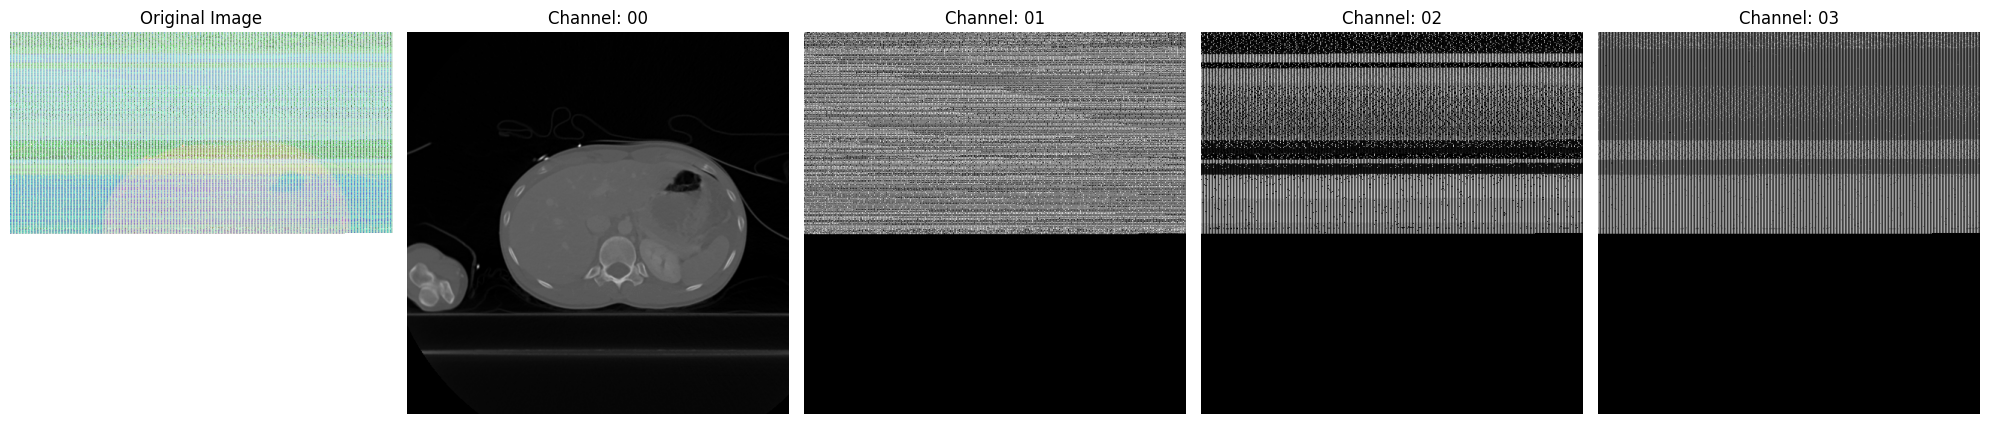

In [107]:
img = load_scan(test_df.dicom_paths.iloc[0])
show_img(img)

In [108]:
%%time
from joblib import Parallel, delayed
file_paths = test_df.dicom_paths.tolist()
_ = Parallel(n_jobs=-1,backend='loky')(delayed(resize_and_save)(file_path)\
                                                  for file_path in tqdm(file_paths))
del _; gc.collect()

100%|██████████| 3/3 [00:00<00:00, 25.80it/s]


CPU times: user 950 ms, sys: 749 ms, total: 1.7 s
Wall time: 2.5 s


28913

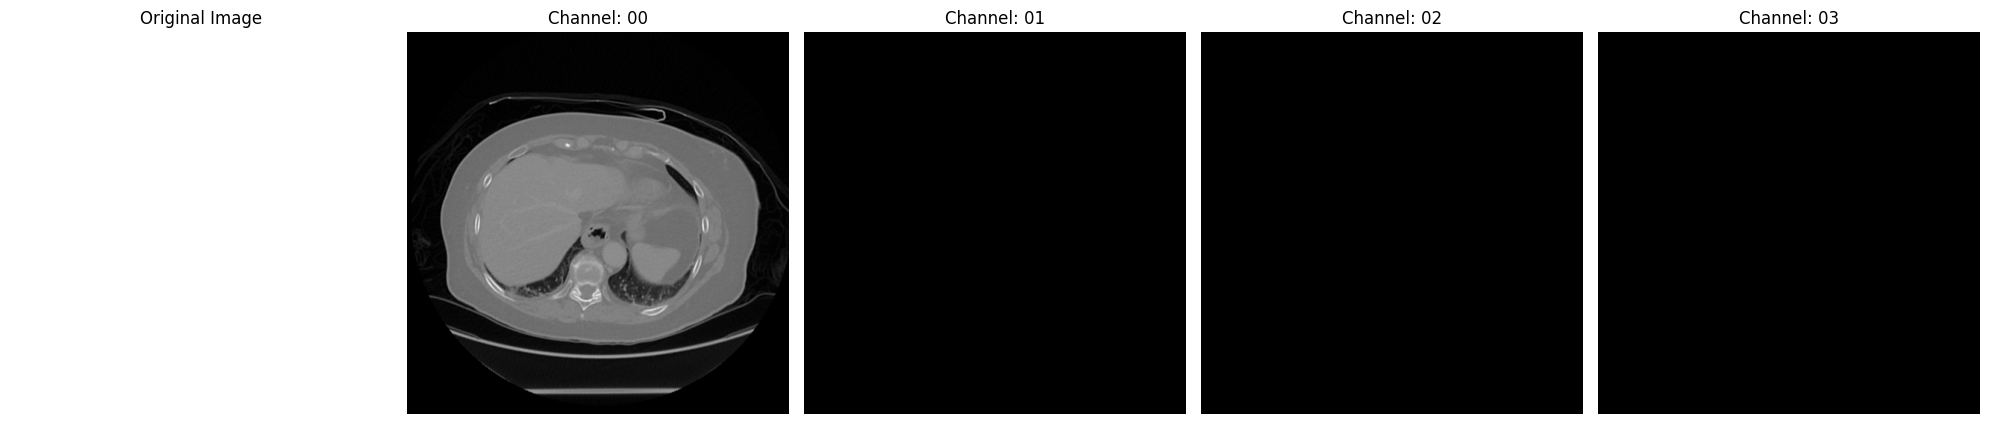

In [109]:
img = load_img(f'{IMG_DIR}/test_images/50046/24574.png')
show_img(img)

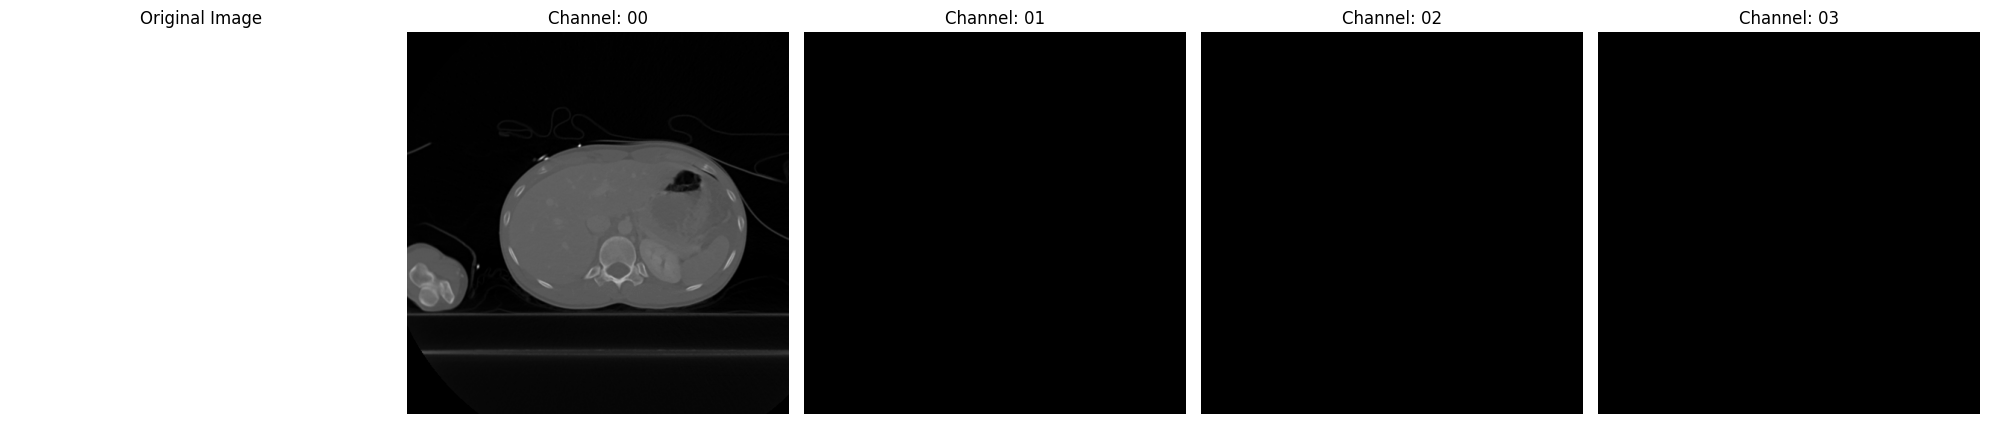

In [110]:
img = load_img(f'{IMG_DIR}/test_images/48843/62825.png')
show_img(img)

In [111]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=4, dtype=tf.uint8)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 4])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

In [112]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
        tars = tf.concat(tars,axis=-1).numpy()
    else:
        imgs = batch
        tars = None
    
    plt.figure(figsize=(size*5, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{tars[img_idx].round(2)}', fontsize=12)
        img = imgs[img_idx,]
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

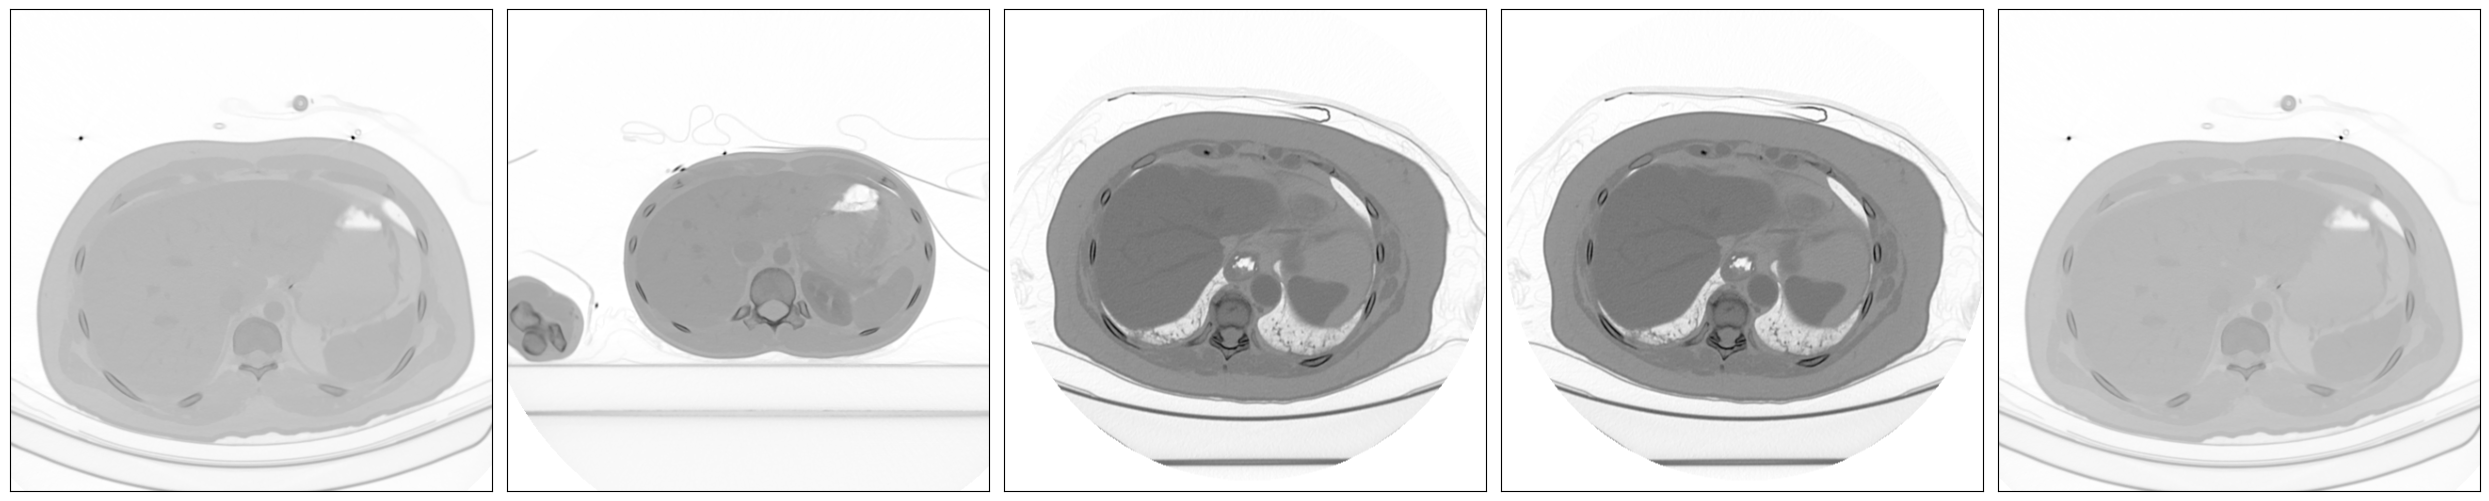

In [113]:
fold_df = test_df.copy()
paths  = fold_df.image_path.tolist()
labels = None
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

In [115]:
def mc_proc(pred):
    argmax = np.argmax(pred, axis=1).astype('uint8')
    one_hot = tf.keras.utils.to_categorical(argmax, num_classes=3)
    return one_hot.astype('uint8')

def sc_proc(pred, thr=0.5):
    proc_pred = (pred > thr).astype('uint8')
    return proc_pred

def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2 + 2 + 3*3), dtype=np.uint8)

    # bowel, extravasation
    proc_pred[:, 0] = sc_proc(pred[:, 0])
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = sc_proc(pred[:, 1])
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = mc_proc(pred[:, 2:5])
    proc_pred[:, 7:10] = mc_proc(pred[:, 5:8])
    proc_pred[:, 10:13] = mc_proc(pred[:, 8:11])

    return proc_pred

def post_proc_v2(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype='float32')

    # bowel, extravasation
    proc_pred[:, 0] = 1 - pred[:, 0] # bowel-healthy
    proc_pred[:, 1] = pred[:, 0] # bowel-injured
    proc_pred[:, 2] = 1 - pred[:, 1] # extra-healthy
    proc_pred[:, 3] = pred[:, 1] # extra-injured
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

In [116]:
# Getting unique patient IDs from test dataset
patient_ids = test_df['patient_id'].unique()

# Initializing array to store predictions
patient_preds = np.zeros(shape=(len(patient_ids), 2*2 + 3*3), dtype='float32')

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    # Query the dataframe for a particular patient
    patient_df = test_df.query("patient_id == @patient_id")
    
    # Initializing model predictions array
    model_preds = np.zeros(shape=(1, 11), dtype=np.float32)
    
    print("="*25)
    print(f"   Patient ID: {patient_id}")
    print("="*25)
    
    # Iterating over each model
    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):
        
        # Getting image paths for a patient
        patient_paths = patient_df.image_path.tolist()

        # Setting batch size based on number of patient paths and dimension of image
        dim = np.prod(img_size)**0.5
        CFG.batch_size = REPLICAS * int(32 * 2)
            
        # Clip batch_sizs to min
        min_bs = 2**np.floor(np.log2(len(patient_paths)))
        CFG.batch_size = min(min_bs, CFG.batch_size)

        # Building dataset for prediction
        dtest = build_dataset(
            patient_paths, 
            batch_size=CFG.batch_size, repeat=True, 
            shuffle=False, cache=False,
            decode_fn=build_decoder(with_labels=False, target_size=img_size),
        )
        
        # Iterating over each fold
        for fold_path in fold_paths:
            with strategy.scope():
                # Loading a model from a fold path
                model = tf.keras.models.load_model(fold_path, compile=False)
            
            # Predicting with the model
            pred = model.predict(dtest, steps = len(patient_paths) / CFG.batch_size, verbose=1)
            pred = np.concatenate(pred, axis=-1).astype('float32') # reducing memory footprint
            pred = pred[:len(patient_paths), :]
            pred = pred.reshape(len(patient_paths), 11)
            pred = np.max(pred, axis=0) # taking max prediction of all ct scans for a patient
            
            # Store model's prediction
            model_preds += pred / (len(fold_paths)*len(MODEL_CONFIGS))
            
            # Deleting variables to free up memory
            del model, pred; gc.collect()
            
            print('\n')
        
        del dtest, patient_paths; gc.collect()
            
    # Adding processed predictions to patient_preds
    patient_preds[pidx, :] += post_proc_v2(model_preds)[0]
    
    del model_preds; gc.collect()

print("Prediction Done!")

Patients :   0%|          | 0/3 [00:00<?, ?it/s]

   Patient ID: 48843


Patients :  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

   Patient ID: 50046
   Patient ID: 63706


Patients : 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

Prediction Done!
